![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Calculate z-aggregates in quantiles (classes) of x and y
</b>
</span>

---
**Notebook version**: `1` (23 Mar 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)

</br>

# **Description**

- By default, x and y are binned into 10 classes and the aggregate of z (mean, median, min, max, counts) is shown in each of the resulting 100 classes (10*10).

</br>

# **Imports**

In [1]:
import importlib.metadata
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")
from diive.configs.exampledata import load_exampledata_parquet
from diive.pkgs.analyses.quantilexyaggz import QuantileXYAggZ
from diive.core.plotting.heatmap_xyz import HeatmapPivotXYZ

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.85.0


In [2]:
# help(QuantileXYAggZ)

</br>

# **Load example data**

In [3]:
df = load_exampledata_parquet()
df.head()

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.121 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


,ET_f,GPP_CUT_16_f,GPP_CUT_84_f,GPP_CUT_REF_f,GPP_DT_CUT_16,GPP_DT_CUT_84,GPP_DT_CUT_REF,LE_f,LE_orig,LW_IN,NEE_CUT_16_f,NEE_CUT_16_orig,NEE_CUT_84_f,NEE_CUT_84_orig,NEE_CUT_REF_f,...,Reco_CUT_84,Reco_CUT_REF,Reco_DT_CUT_16,Reco_DT_CUT_84,Reco_DT_CUT_REF,Reco_DT_CUT_REF_SD,Rg_f,Rg_orig,RH,SWC_FF0_0.15_1,Tair_f,Tair_orig,Ustar_CUT_REF_Thres,VPD_f,VPD_orig
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:15:00,0.290,0.510,-0.082,0.705,0.0,0.0,0.0,13.093,NaN,194.913,1.376,NaN,1.537,NaN,1.595,...,1.455,2.300,1.252,1.908,1.613,0.510,0.0,0.0,31.933,34.977,-1.618,-1.618,0.288,1.339,1.339
2013-01-01 00:45:00,0.290,0.512,-0.084,0.708,0.0,0.0,0.0,13.093,NaN,193.568,1.376,NaN,1.537,NaN,1.595,...,1.454,2.303,1.241,1.914,1.616,0.512,0.0,0.0,32.600,34.977,-1.630,-1.630,0.288,1.337,1.337
2013-01-01 01:15:00,0.290,0.514,-0.086,0.710,0.0,0.0,0.0,13.066,NaN,193.135,1.376,NaN,1.537,NaN,1.595,...,1.452,2.305,1.230,1.920,1.619,0.515,0.0,0.0,38.867,34.971,-1.644,-1.644,0.288,1.335,1.335
2013-01-01 01:45:00,0.290,1.354,-0.088,1.771,0.0,0.0,0.0,13.066,NaN,192.083,0.538,0.538,1.537,NaN,0.538,...,1.450,2.308,1.219,1.926,1.622,0.518,0.0,0.0,37.767,34.975,-1.657,-1.657,0.288,1.332,1.332
2013-01-01 02:15:00,0.377,0.545,-0.080,0.797,0.0,0.0,0.0,16.995,NaN,192.677,1.544,NaN,1.709,NaN,1.765,...,1.630,2.562,1.347,2.105,1.790,0.578,0.0,0.0,39.533,34.967,-0.567,-0.567,0.288,3.545,3.545


## Make subset

In [4]:
# Make subset of three required columns
vpd_col = 'VPD_f'
ta_col = 'Tair_f'
swin_col = 'Rg_f'
df = df[[vpd_col, ta_col, swin_col]].copy()

In [5]:
# Use data May and Sep
df = df.loc[(df.index.month >= 5) & (df.index.month <= 9)].copy()

In [6]:
# Use daytime data 
daytime_locs = (df[swin_col] > 0)
df = df[daytime_locs].copy()
df = df.dropna()

In [7]:
df

,VPD_f,Tair_f,Rg_f
TIMESTAMP_MIDDLE,,,
2013-05-01 05:15:00,2.843,7.667,2.912
2013-05-01 05:45:00,1.425,5.967,21.093
2013-05-01 06:15:00,1.460,6.167,50.277
2013-05-01 06:45:00,1.587,6.700,96.650
2013-05-01 07:15:00,1.586,6.900,162.190
...,...,...,...
2022-09-30 16:15:00,0.156,3.217,111.235
2022-09-30 16:45:00,0.146,3.170,77.094
2022-09-30 17:15:00,0.121,3.203,56.054


</br>

# (1) **Calculate mean of z in 10 quantile classes of x and y**

In [8]:
q = QuantileXYAggZ(
    x=df[swin_col],
    y=df[ta_col],
    z=df[vpd_col],
    n_quantiles=10,
    min_n_vals_per_bin=3,
    binagg_z='mean'
)
q.run()
pivotdf = q.pivotdf.copy()
pivotdf

BIN_Rg_f,0,10,20,30,40,50,60,70,80,90
BIN_Tair_f,,,,,,,,,,
0,0.738029,0.882306,0.907608,0.783157,0.882975,1.210846,1.484725,1.906702,2.124990,2.569857
10,1.109053,1.247962,1.250752,1.205217,1.362100,1.741093,2.281106,2.827544,3.221641,3.404728
20,1.359257,1.609306,1.517805,1.466337,1.760117,2.230852,2.803953,3.519970,3.936581,4.287607
30,1.803614,1.966310,1.899482,1.815355,2.243760,3.295720,3.494331,4.207591,4.818127,5.080783
40,2.191474,2.617581,2.407728,2.455835,2.951037,3.803165,4.380593,4.944201,5.332908,6.178695
50,3.147071,3.443443,3.602171,3.537326,3.662930,4.668226,5.442874,6.001373,6.345775,7.025564
60,4.698872,5.107422,5.021604,5.149920,5.501511,6.077052,6.522451,7.160304,7.789453,8.057696
70,6.514295,6.915953,7.306498,7.352755,7.474100,8.062731,8.563870,8.860974,9.411137,9.825721
80,9.090340,9.430653,9.720280,9.983868,10.115974,10.705982,11.236660,11.251576,12.075453,12.163915


</br>

## Plot

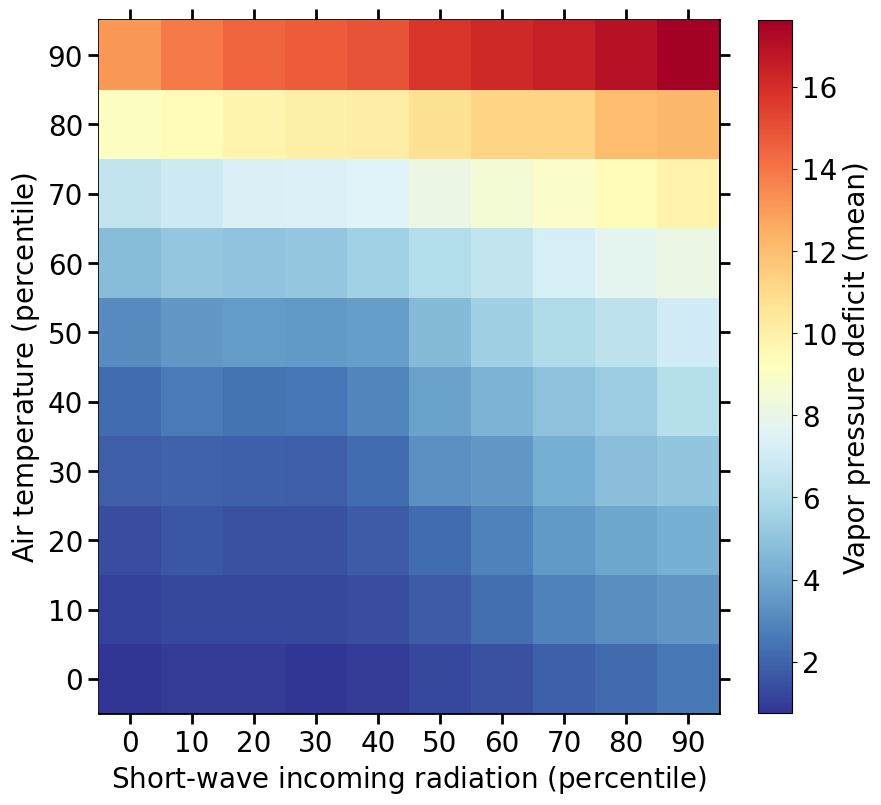

In [9]:
hm = HeatmapPivotXYZ(pivotdf=pivotdf)
hm.plot(
    cb_digits_after_comma=0,
    xlabel=r'Short-wave incoming radiation ($\mathrm{percentile}$)',
    ylabel=r'Air temperature ($\mathrm{percentile}$)',
    zlabel=r'Vapor pressure deficit (mean)'
)

</br>

# (2) **Calculate counts of z in 100 quantile classes of x and y**

In [10]:
q = QuantileXYAggZ(
    x=df[swin_col],
    y=df[ta_col],
    z=df[vpd_col],
    n_quantiles=100,
    min_n_vals_per_bin=3,
    binagg_z='count'
)
q.run()
pivotdf = q.pivotdf.copy()
pivotdf

BIN_Rg_f,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
BIN_Tair_f,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,8.0,9.0,8.0,7.0,11.0,6.0,8.0,11.0,8.0,6.0,8.0,8.0,8.0,18.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,3.0,4.0,8.0,11.0,11.0,12.0,8.0,9.0,7.0,6.0,4.0,7.0,8.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.0,5.0,8.0,3.0,6.0,6.0,7.0,6.0,7.0,11.0,8.0,7.0,11.0,14.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.0,9.0,7.0,9.0,8.0,8.0,8.0,12.0,4.0,5.0,7.0,6.0,7.0,7.0,7.0,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN
4,8.0,7.0,NaN,6.0,6.0,5.0,8.0,7.0,7.0,5.0,4.0,7.0,5.0,9.0,8.0,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,10.0,12.0,12.0,19.0,9.0,15.0,12.0,9.0,12.0,13.0,20.0,17.0,14.0,11.0,10.0
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,11.0,12.0,13.0,9.0,16.0,22.0,18.0,8.0,16.0,5.0,21.0,13.0,24.0,8.0,5.0
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,17.0,10.0,13.0,15.0,14.0,15.0,10.0,16.0,21.0,19.0,12.0,10.0,11.0,6.0


</br>

## Plot
- In this case there are many classes (100*100), therefore it is recommended to manually define `tickpos` and `ticklabels`.

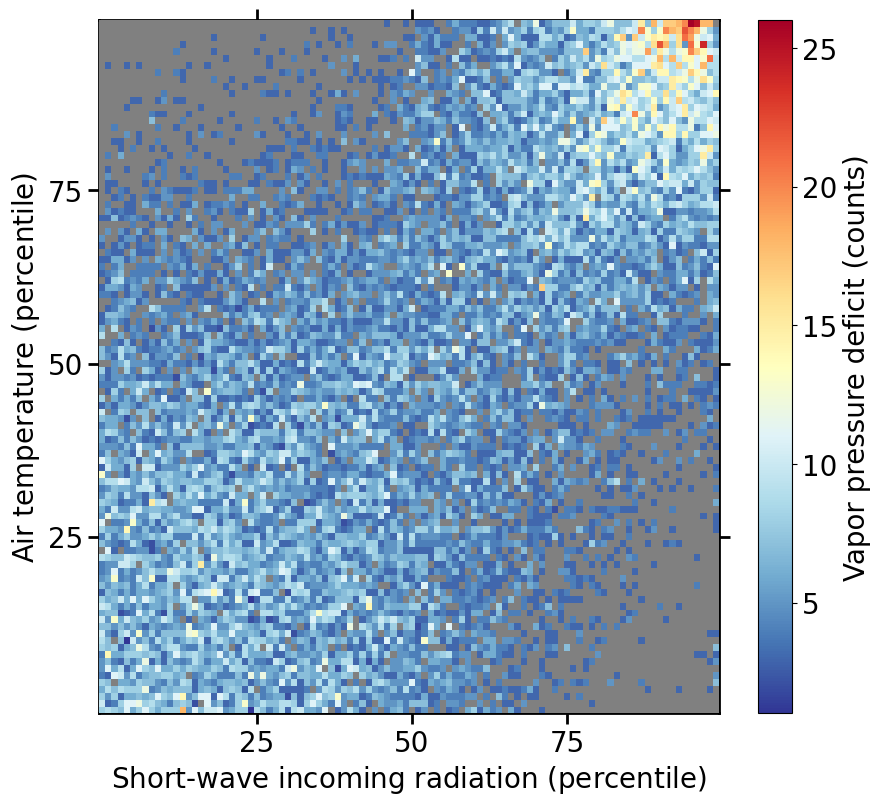

In [11]:
hm = HeatmapPivotXYZ(pivotdf=pivotdf)
hm.plot(
    cb_digits_after_comma=0,
    xlabel=r'Short-wave incoming radiation ($\mathrm{percentile}$)',
    ylabel=r'Air temperature ($\mathrm{percentile}$)',
    zlabel=r'Vapor pressure deficit (counts)',
    tickpos=[25, 50, 75],
    ticklabels=['25', '50', '75']
)

</br>

# **End of notebook**

In [12]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2025-01-23 12:40:28
